## Testing inference

In [1]:
from datasets import data_merge_R
from transformers import *
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from networks import get_model
from networks import SSAN_R
from utils import *
from utils.performance import performance_double_val
%load_ext autoreload
%autoreload 2

In [2]:
def inference(PATH, img_size=112, type='test', train_datasets='M1', batch_size=256):
    num_workers = 8

    data_bank = data_merge_R.data_merge()
    model = SSAN_R().cuda()
    state = torch.load(PATH)
    model.load_state_dict(state['state_dict'])

 # Original input data loader
    test_data_dic = data_bank.get_datasets(type=type, img_size=img_size, transform=transformer_test_video())
    test_loader = DataLoader(test_data_dic, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    

    model.eval()
    with torch.no_grad():
        scores = []
        for i, sample_batched in enumerate(tqdm(test_loader)):
            image_x, label = sample_batched["image_x"].cuda(), sample_batched["label"].cuda()

            cls_x1_x1, fea_x1_x1, fea_x1_x2, _ = model(image_x, image_x)
            score_norm = torch.softmax(cls_x1_x1, dim=1)[:, 1]

            for ii in range(image_x.shape[0]):
                scores.append("{} {}\n".format(score_norm[ii], label[ii][0]))
                        
        map_score_val_filename = os.path.join('./', f"test_score_{img_size}_{train_datasets}.txt")
        print("score: write test scores to {}".format(map_score_val_filename))
        with open(map_score_val_filename, 'w') as file:
            file.writelines(scores)

        _, _, _, HTER, auc_test, _ = performances_val(map_score_val_filename)
        best_epoch = state['epoch']
        print(best_epoch)
        return best_epoch, HTER, auc_test



In [13]:
train_datasets = 'MV2'
img_size=112
# PATH = '/home/user/ml_projects/Yeldar/results/ssan/exp3_champ_modelV1/SSAN_R_best_v1.pth'
PATH = '/home/user/ml_projects/Yeldar/results/ssan/exp3_champ_modelV1/SSAN_R_best_v2.pth'

# PATH = '/home/user/ml_projects/Yeldar/SSAN/results/SynthezExperiment/model/SSAN_R_best.pth' .. - Mnew
# PATH = '/home/user/ml_projects/Yeldar/SSAN/results/Experiment_25.3_best/model/SSAN_R_best.pth'
best_epoch, HTER, auc_test = inference(PATH, img_size=img_size, type='test', train_datasets=train_datasets, batch_size=256)
# best_epoch
sc_p = os.path.join("/".join(PATH.split('/')[:-2]), "score")
total_epoch = max([int(x.split('_')[-1]) for x in os.listdir(sc_p)])
print("epoch:{:d}/{:d}, HTER={:.4f}, AUC={:.4f}".format(best_epoch, total_epoch, HTER, auc_test))

/home/user/anaconda3/envs/ss/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading dataset, number: 58775
Total number: 58775


100%|██████████| 230/230 [01:08<00:00,  3.38it/s]


score: write test scores to ./test_score_112_MV2.txt
9


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/ml_projects/Yeldar/results/ssan/score'

# Model's metrics

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


def find_best_threshold_with_gini(y_true, y_pred_probs):
    """
    Find the best threshold for a binary classifier using the Gini index.

    Parameters:
        y_true (array-like): The true binary labels (0 or 1).
        y_pred_probs (array-like): The predicted probabilities from the classifier.

    Returns:
        best_threshold (float): The threshold that maximizes the Gini index.
        best_gini (float): The maximum Gini index achieved.
    """
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    
    # Calculate the AUC-ROC
    auc = roc_auc_score(y_true, y_pred_probs)
    
    # Initialize variables to keep track of the best threshold and Gini index
    best_gini = 0
    best_threshold = None
    
    # Iterate through each threshold in the ROC curve
    for i, threshold in enumerate(thresholds):
        # Calculate the Gini index for the current threshold
        current_gini = tpr[i] - fpr[i]
        
        # Update the best threshold and Gini index if the current one is better
        if current_gini > best_gini:
            best_gini = current_gini
            best_threshold = threshold
    
    return best_threshold, best_gini


def overall_result(y_, y_predicted):
# save confusion matrix and slice into four pieces

    conf_matrix = confusion_matrix(y_, y_predicted)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]


    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    conf_far = FN/float(TP + FN)
    conf_frr = FP/float(TN + FP)

    result_s = {}
    result_s['Accuracy']           = [str(round(conf_accuracy,4)*100)+'%']
#    result_s['Mis-Classification'] = [str(round(conf_misclassification,2)*100)+' %']
#     result_s['Sensitivity']        = [round(conf_sensitivity,2)]
#     result_s['Specificity']        = [round(conf_specificity,2)]
    result_s['Recall']        = [str(round(conf_sensitivity,4)*100)+'%']
    result_s['Precision']          = [str(round(conf_precision,4)*100)+'%']
    result_s['F1 Score']           = [str(round(conf_f1,4)*100)+'%']
    result_s['FRR']                = [str(round(conf_far,4)*100)+'%']
    result_s['FAR']                = [str(round(conf_frr,4)*100)+'%']
    #result_s['inference_time']     = [str(round(sum(inferences_time),2))+ 's']
    #result_s['MCC']                = [round(matthews_corrcoef(y_, y_predicted),2)]
    

    df_result           = pd.DataFrame(result_s)
    
    return df_result

In [ ]:
def read_calc_plot(map_score_val_filename):
    with open(map_score_val_filename, 'r') as file:
        lines = file.readlines()
    val_scores = []
    val_labels = []
    count = 0.0
    for line in lines:
        # try:
        count += 1
        tokens = line.split()
        score = float(tokens[0])
        label = float(tokens[1])  # int(tokens[1])
        val_scores.append(score)
        val_labels.append(label)
    y_true = np.array(val_labels)
    y_true = y_true.astype(int)
    y_pred = np.array(val_scores)

    # # Find the best threshold and Gini index
    best_threshold, best_gini = find_best_threshold_with_gini(y_true, y_pred)

    print(f"Best threshold: {best_threshold}")
    print(f"Best Gini index: {best_gini}")

    # thrs = range(best_thr)
    # for thr in thrs:

    # best_threshold = 0.996
    # print(f"Threshold: {best_threshold}")

    y_pred = [1 if score>best_threshold else 0 for score in y_pred] 
    # 1 = live  
    #0=mask

    metrics = overall_result(y_true, y_pred)
    print(metrics)
    colors_lightsteelblue = ['#CAE1FF', '#BCD2EE', '#A2B5CD', '#6E7B8B']

    fig,ax=plt.subplots(1,1,figsize=(5,5))
    sns.heatmap(confusion_matrix(y_true,y_pred),ax=ax,xticklabels=['pred_mask', 'pred_live'],
                yticklabels=['mask', 'live'],
                annot=True,fmt='g',annot_kws={"size": 14},
            cmap=colors_lightsteelblue[::1],alpha=0.7,linewidths=5,linecolor=colors_lightsteelblue[2])
    fig.text(s='Mask Detection th=...',size=13,fontweight='bold',
                fontname='monospace',color='black',y=0.92,x=0.28,alpha=0.8)
    sns.set(font_scale=1.1)
    plt.show()
    return best_threshold

Best threshold: 0.977916419506073
Best Gini index: 0.9743367061908613
  Accuracy  Recall Precision F1 Score    FRR    FAR
0    98.4%  98.18%    99.81%   98.98%  1.82%  0.74%


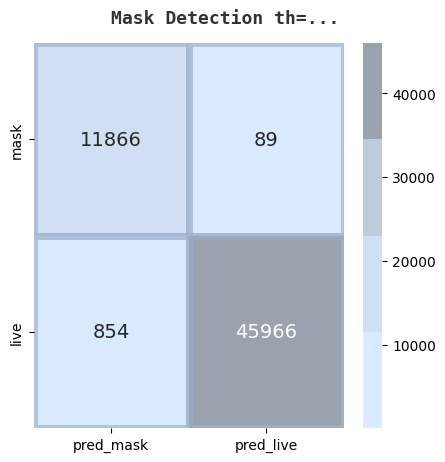

In [6]:
map_score_val_filename = 'test_score_112_Mnew.txt'
best_threshold = read_calc_plot(map_score_val_filename)

Best threshold: 0.8667172789573669
Best Gini index: 0.9530781188391395
  Accuracy  Recall Precision            F1 Score                  FRR    FAR
0    96.8%  96.22%    99.76%  97.96000000000001%  3.7800000000000002%  0.91%


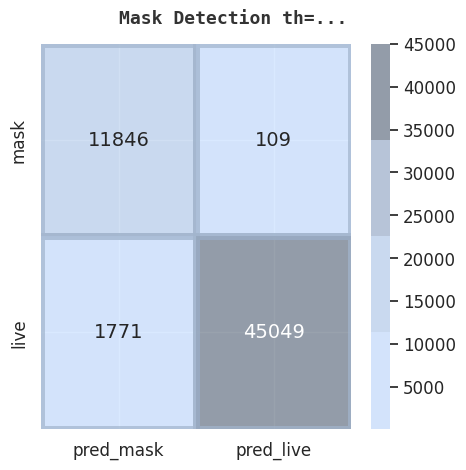

In [10]:
map_score_val_filename = 'test_score_112_MV3.txt'
best_threshold = read_calc_plot(map_score_val_filename)

Best threshold: 0.9987378716468811
Best Gini index: 0.8957470355067442
             Accuracy  Recall Precision F1 Score    FRR    FAR
0  95.00999999999999%  95.16%    98.52%   96.81%  4.84%  5.59%


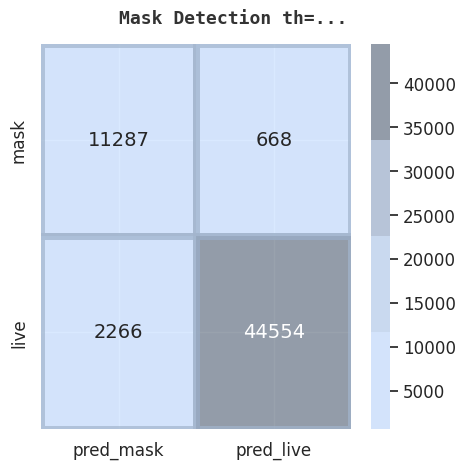

In [14]:
map_score_val_filename = 'test_score_112_MV1.txt'
best_threshold = read_calc_plot(map_score_val_filename)

Best threshold: 0.3537839651107788
Best Gini index: 0.5272675316146214
  Accuracy              Recall           Precision F1 Score     FRR     FAR
0   79.46%  81.58999999999999%  91.71000000000001%   86.36%  18.41%  28.87%


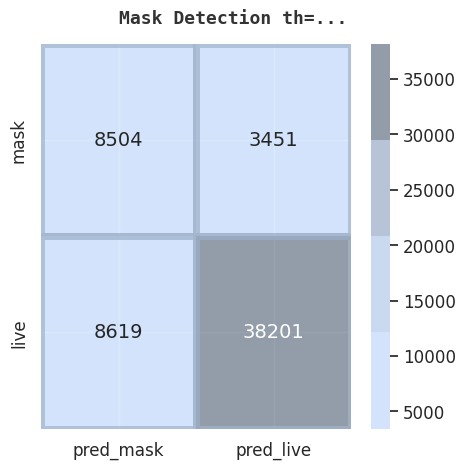

In [15]:
map_score_val_filename = 'test_score_112_MV2.txt'
best_threshold = read_calc_plot(map_score_val_filename)

## Saving not correctly labeled images

In [16]:
map_score_val_filename = 'test_score_112_Mnew.txt'

with open(map_score_val_filename, 'r') as file:
    lines = file.readlines()
val_scores = []
val_labels = []
data = []
count = 0.0
for line in lines:
    # try:
    count += 1
    tokens = line.split()
    score = float(tokens[0])
    label = int(tokens[1])  # int(tokens[1])
    val_scores.append(score)
    val_labels.append(label)

In [17]:
thr = 0.977916419506073
cnt = 0
inds = []
for i in range(len(val_labels)):
    pred_label = 0 if val_scores[i] < thr else 1
    if val_labels[i]!=pred_label & pred_label == 1:
        # print(i, val_scores[i], val_labels[i], pred_label)
        inds.append(i)
        cnt += 1
print(cnt)

89


In [ ]:
import shutil

# Iterate over each row in the DataFrame
save_fold = "/home/user/ml_projects/Yeldar/results/ssan/wrong_identified_labels"
for i, row in df.loc[inds].iterrows():
    file_path = row['fname']
    print(row['fname'], val_scores[inds[i]])
    # file_path = file_path.replace('/mnt/8TB', '/media/user/685b3289-4051-4530-9827-ef770d2e3f28')
    # Check if the file exists to avoid errors
    if os.path.isfile(file_path):
        shutil.copy(file_path, save_fold)


## Analyzing density plots

In [39]:
import os
import pandas as pd
# df = pd.read_csv('data/full_mask_detection_dataset.csv')
# df = df.rename(columns={'image_name': 'fname'})
# df = pd.read_csv('data/completed_test.csv')
df['img_basename'] = df['image_name'].apply(lambda x: os.path.basename(x))
# df[df['label']==1].groupby(['dataset']).count()
df


,image_name,subject,dataset,label,img_basename
0,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1,IDRND,1,real_1_01.png
1,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_10,IDRND,1,real_10_01.png
2,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_100,IDRND,1,real_100_01.png
3,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1000,IDRND,1,real_1000_01.png
4,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1001,IDRND,1,real_1001_01.png
...,...,...,...,...,...
72335,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_75_IMG_6583.jpg
72336,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_80_IMG_6583.jpg
72337,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_90_IMG_6583.jpg
72338,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_95_IMG_6583.jpg


In [28]:
# map_score_val_filename = 'test_score_112_Mnew.txt'

# with open(map_score_val_filename, 'r') as file:
#     lines = file.readlines()
# val_scores = []
# val_labels = []
# data = []
# count = 0.0
# for line in lines:
#     # try:
#     count += 1
#     tokens = line.split()
#     score = float(tokens[0])
#     label = int(tokens[1])  # int(tokens[1])
#     val_scores.append(score)
#     val_labels.append(label)


dpath = './data/test_multidomain_mask_dataset.xlsx'
# dpath = '/mnt/8TB/ml_projects_yeldar/patchnet/train/train_list.csv'
test_data = pd.read_excel(dpath)
columns = ['cropped_face_path', 'label', 'dataset']
test_data = test_data[columns]
# test_data['img_basename'] = test_data['fname'].apply(lambda x: os.path.basename(x))
test_data['score'] = val_scores
test_data['pred_label'] = val_labels
test_data['label'] = test_data['label'].apply(lambda x: 1 if x=='live' else 0)
test_data
# len(val_scores)

,cropped_face_path,label,dataset,score,pred_label
0,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,live,M1,0.999994,1
1,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,live,M3,0.999882,1
2,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,mask,M4,0.000046,0
3,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,mask,M4,0.326267,0
4,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,live,M4,0.999986,1
...,...,...,...,...,...
58770,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,mask,M4,0.000132,0
58771,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,live,M1,0.999993,1
58772,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,live,M1,0.999903,1
58773,/22tb/Nurmukhammed/SILICON_MASKS_DATASETS/CROP...,live,M1,0.999994,1


In [32]:
test_data[test_data['pred_label']==1].groupby(['dataset'])['score'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
M1,32897.0,0.996891,0.045731,0.000133,0.999959,0.999987,0.999995,1.000000
M2,2083.0,0.996383,0.043458,0.005180,0.999905,0.999968,0.999989,0.999999
M3,2921.0,0.947424,0.191262,0.000003,0.999331,0.999957,0.999991,1.000000
M4,4042.0,0.991262,0.081492,0.000522,0.999917,0.999972,0.999989,1.000000
M5,195.0,0.999990,0.000019,0.999877,0.999995,0.999997,0.999998,1.000000
M6,1614.0,0.973066,0.130808,0.000033,0.999592,0.999952,0.999989,0.999999
M7,3068.0,0.999491,0.012314,0.329783,0.999906,0.999974,0.999991,1.000000


In [33]:
test_data[test_data['pred_label']=='mask'].groupby(['dataset'])['score'].describe()

,count,mean,std,min,25%,50%,75%,max


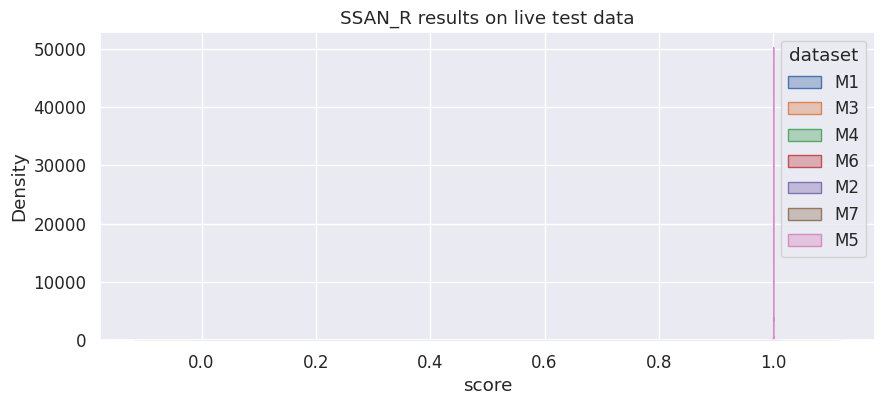

In [34]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=test_data[test_data['label']=='live'], x="score", hue="dataset", fill=True, common_norm=False, alpha=0.4, legend=True)
plt.title('SSAN_R results on live test data')
plt.show()

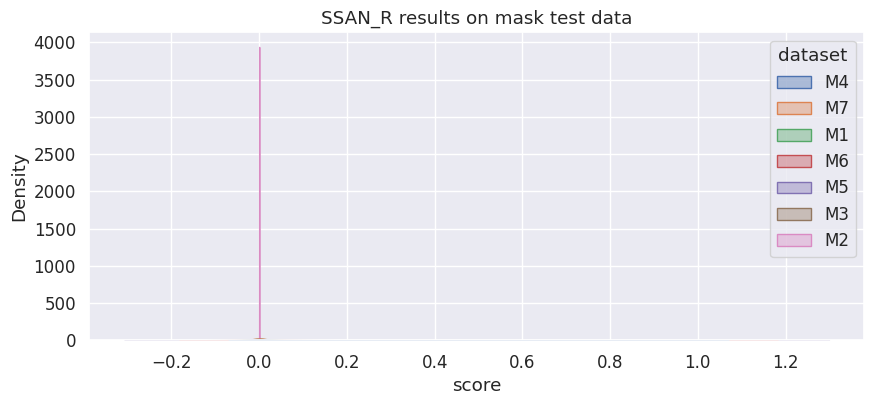

In [35]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=test_data[test_data['label']=='mask'], x="score", hue="dataset", fill=True, common_norm=False, alpha=0.4, legend=True)
# sns.displot(data=test_data[test_data['label']==1], x="score")
plt.title('SSAN_R results on mask test data')
plt.show()

In [ ]:
for dataset in  test_data[test_data['label']==1]['dataset'].unique():
    y_true = np.ones(len( test_data[test_data['label']==1][test_data['dataset']==dataset]['score']))
    y_pred =  test_data[test_data['label']==1][test_data['dataset']==dataset]['score']
    y_pred = [1 if score>best_threshold else 0 for score in y_pred]
    print(dataset,round(sum(y_pred)/len(test_data[test_data['label']==1][test_data['dataset']==dataset]['score']), 3)*100,'%')
    # print(dataset,sum(y_pred), len( test_data[test_data['label']==1][test_data['dataset']==dataset]['score']))


In [ ]:
print('results_with_random_crop_mask \n')

for dataset in  test_data[test_data['label']==0]['dataset'].unique():
    y_true = np.ones(len( test_data[test_data['label']==0][test_data['dataset']==dataset]['score']))
    y_pred =  test_data[test_data['label']==0][test_data['dataset']==dataset]['score']
    y_pred = [1 if score<best_threshold  else 0 for score in y_pred]
    # print(dataset,sum(y_pred), len( test_data[test_data['label']==0][test_data['dataset']==dataset]['score']))
    print(dataset,round(sum(y_pred)/len(test_data[test_data['label']==0][test_data['dataset']==dataset]['score']), 3)*100,'%')
    # print(dataset,round(sum(y_pred)))

In [18]:
train/val/test

149/20/20 - 190


209/60/60 - 330


0.058055555555555555

In [19]:
330/190

1.736842105263158